In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
from pyspark import SparkFiles
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType


spark = SparkSession.builder.getOrCreate()

In [2]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


### Reading Product master excel files

In [3]:
Order_pattern = "Ordering pattern - Book.xlsx"

In [6]:
ordering_patter_sheets = pd.ExcelFile(Order_pattern).sheet_names

In [14]:
master_file = pd.read_excel('Product_detail_master.xlsx')
master_file_df = spark.createDataFrame(master_file)
master_file_df = master_file_df.withColumnRenamed('Material - Key', 'Material_Key')

In [15]:
master_file_df.printSchema()

root
 |-- Plant - Key: long (nullable = true)
 |-- Plant - Medium Text: string (nullable = true)
 |-- Product Group: string (nullable = true)
 |-- Product Code: string (nullable = true)
 |-- Profit Center - Key: long (nullable = true)
 |-- Profit Center - Text: string (nullable = true)
 |-- Created Date: string (nullable = true)
 |-- Material_Key: string (nullable = true)
 |-- Material - Text: string (nullable = true)
 |-- Material Plant - Key (Not Compounded): string (nullable = true)
 |-- MRP Group: string (nullable = true)
 |-- Material type: string (nullable = true)
 |-- Material group: string (nullable = true)
 |-- Planning Strategy Gr: long (nullable = true)
 |-- Prod.hierarchy: string (nullable = true)
 |-- Product Hierarchy Missing: string (nullable = true)
 |-- Material Plant - Contract(Yes/No) (Key): string (nullable = true)
 |-- Incomplete PH: string (nullable = true)
 |-- Base Unit: string (nullable = true)
 |-- PO Unit: string (nullable = true)
 |-- SAP Revision: long (nul

### Exploring order file schema and gather data from all sheets in excel file

In [10]:
common_schema = {
    "WO": StringType(),
    "Part Number": StringType(),
    "Description": StringType(),
    "Quantity":IntegerType(),
    "UM":StringType()
    # Add more columns as needed
}

pyspark_schema = StructType([StructField(col, dtype, True) for col, dtype in common_schema.items()])

In [11]:
final_df = None
for sheet_name in ordering_patter_sheets:
    sheet_df = pd.read_excel(Order_pattern, sheet_name)
    pyspark_df = spark.createDataFrame(sheet_df, schema=pyspark_schema)
    if final_df is None:
        final_df = pyspark_df
    else:
        final_df = final_df.union(pyspark_df)
final_df = final_df.withColumnRenamed('Part Number', 'part_number')

In [12]:
final_df.printSchema()

root
 |-- WO: string (nullable = true)
 |-- part_number: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- UM: string (nullable = true)



### Aggregating data to get insights on SKU ordering

In [43]:
aggregate_order_qty = final_df.groupBy('part_number','Description', 'UM').agg(
    sum("Quantity").alias("total_orders"),
    avg("Quantity").alias("average_orders"),
    median("Quantity").alias("median_orders"), 
    mode("Quantity").alias("mode_orders"),
    min("Quantity").alias("min_orders"),
    max("Quantity").alias("max_orders"),
    count("part_number").alias("frequency")
)


### Combine marster file with aggregate

In [44]:
combined_data = master_file_df.join(aggregate_order_qty, master_file_df.Material_Key == aggregate_order_qty.part_number, 'left').select('Material_Key','Description','Manufacturer','UM','total_orders','average_orders','median_orders','mode_orders','min_orders','max_orders','frequency','median_orders','mode_orders','min_orders','max_orders','frequency')
combined_data.count()

5532

### converting pyspark dataframe to padas

In [45]:
pandas_df = combined_data.toPandas()

In [46]:
pandas_df.to_excel('Aggregate_data_for_charts.xlsx', index=False)

### Plotting orders of sku's to analyse trends

In [57]:
import matplotlib.pyplot as plt

In [58]:
final_df = final_df.withColumnRenamed('Part Number', 'part_number')

In [59]:
Sku_order_df = final_df.select('WO', 'part_number', 'Quantity', 'UM')

In [83]:
# selected_sku = input("Enter sku: ")
selected_sku_df = Sku_order_df.filter(col("part_number") == '21-042023-06')

In [85]:
selected_sku_df.show()

+-------+------------+--------+---+
|     WO| part_number|Quantity| UM|
+-------+------------+--------+---+
|FS_WK49|21-042023-06|    1500| EA|
|FS_WK36|21-042023-06|    1700| EA|
|FS_WK44|21-042023-06|    3200| EA|
|FS_WK37|21-042023-06|     400| EA|
+-------+------------+--------+---+



In [86]:
sku_order_pandas_df = selected_sku_df.toPandas()

In [ ]:
21-042023-06 - 6800 4 1700 100, 2500, 300
Multiple excel with all possible aggregation combinations as excel
Different charts possible as png images


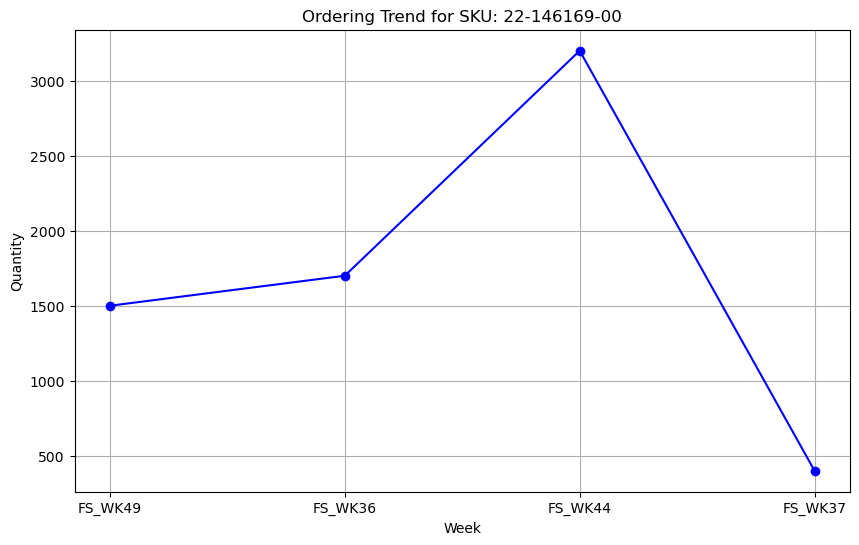

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(sku_order_pandas_df['WO'], sku_order_pandas_df['Quantity'], marker='o', linestyle='-', color='b')
plt.title(f'Ordering Trend for SKU: {selected_sku}')
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()